In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBRFClassifier
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

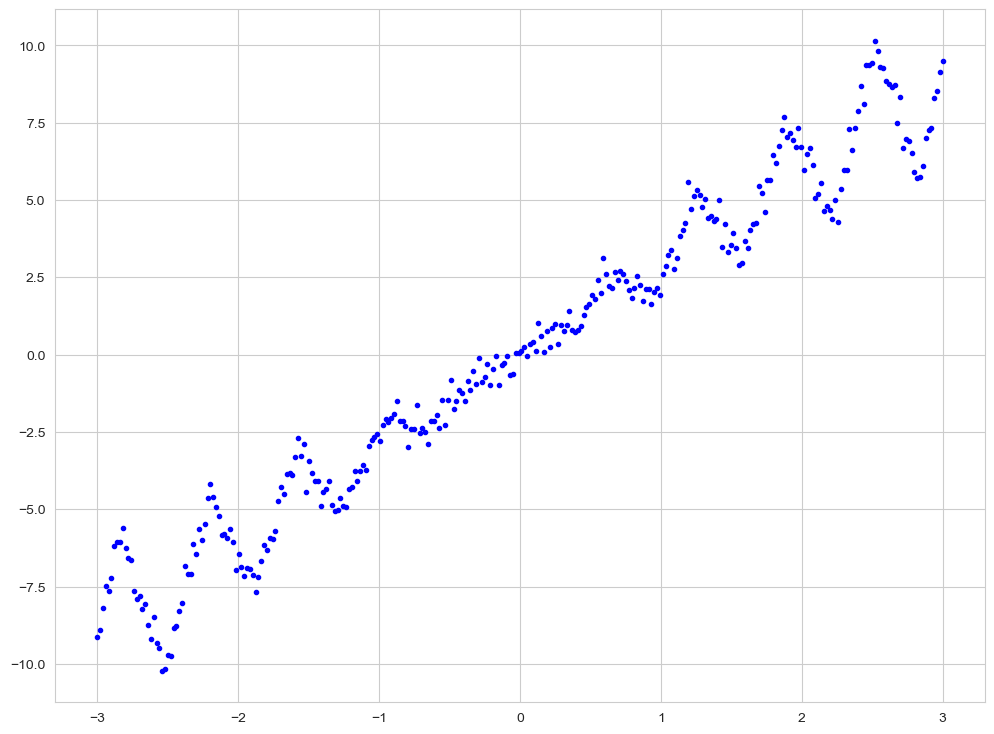

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$", i=0):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

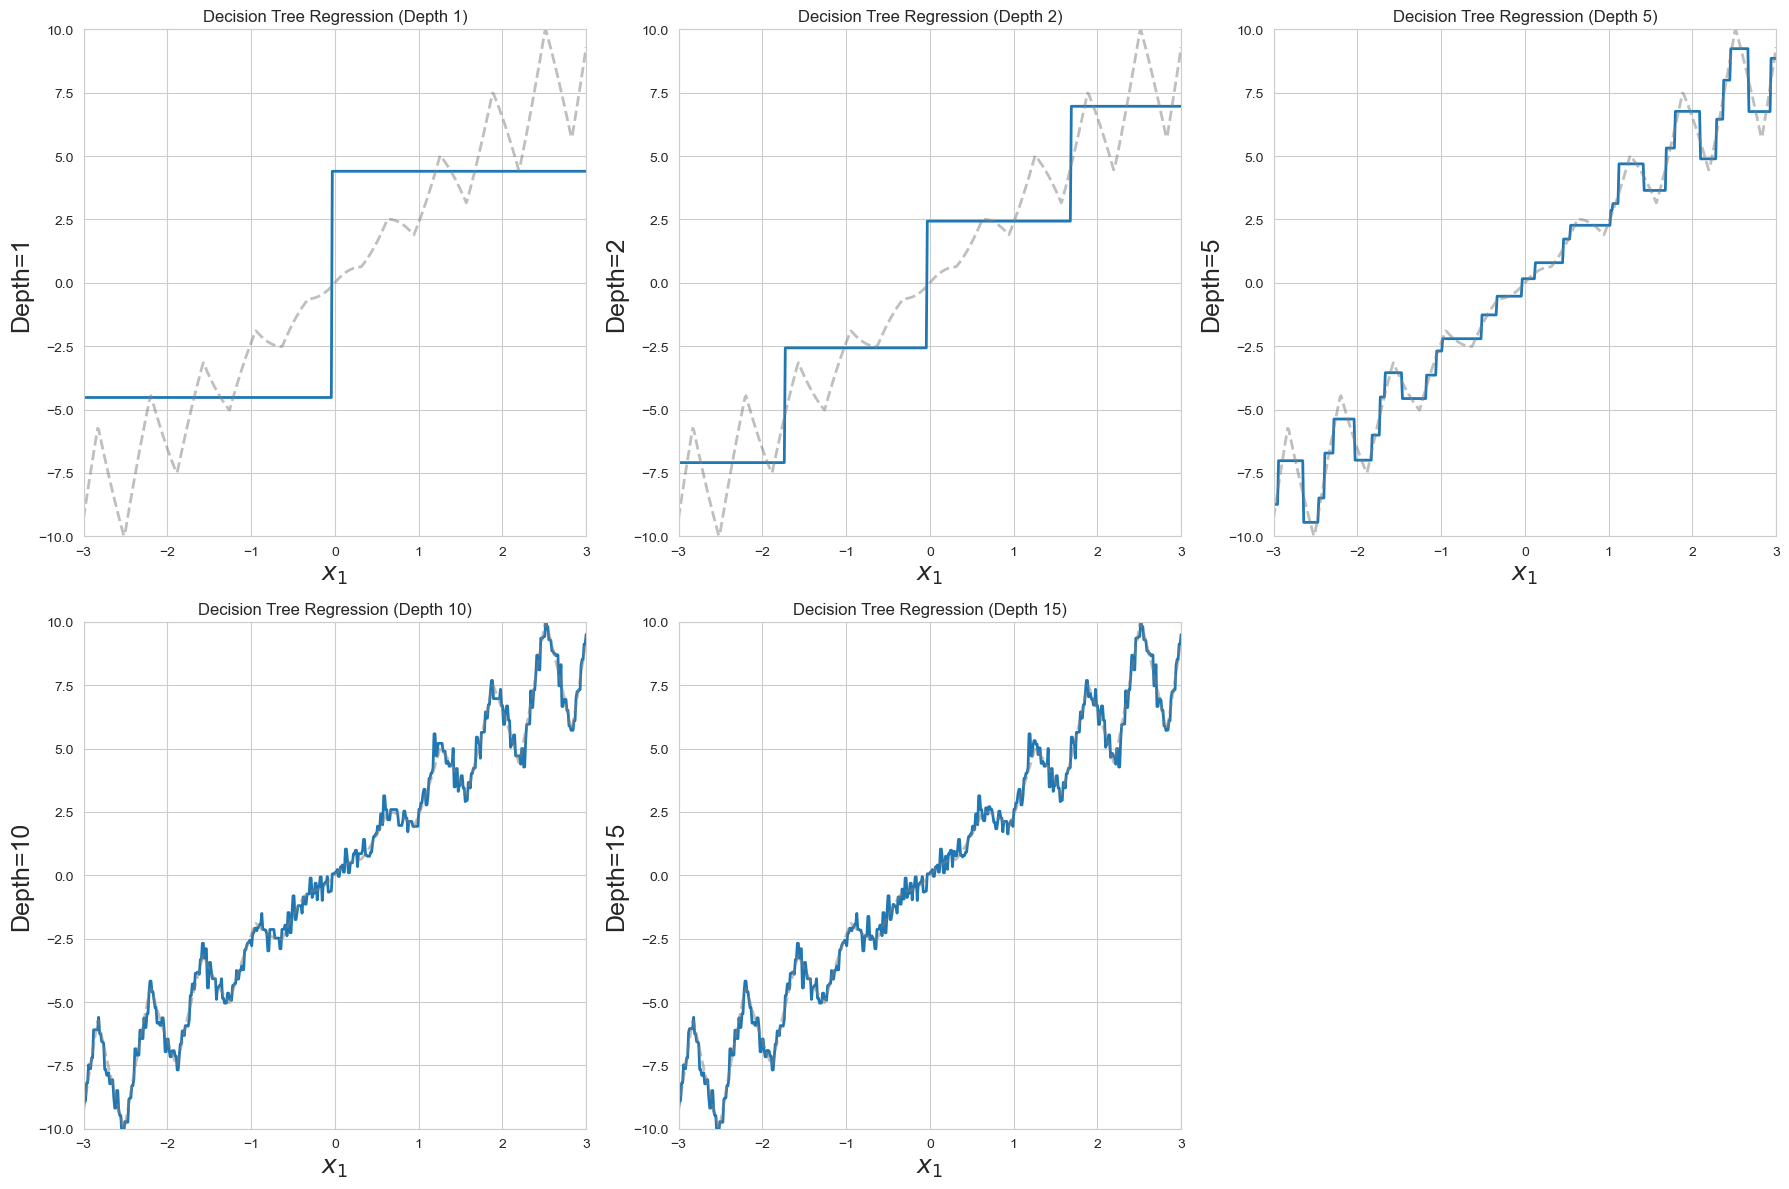

In [5]:
depths = [1, 2, 5, 10, 15]
plt.figure(figsize=(18, 12))
for i, depth in enumerate(depths, 1):
    plt.subplot(2, 3, i)
    tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree_reg.fit(X, y)
    plot_regression_predictions(tree_reg, X, y, ylabel=f"Depth={depth}")

    x_background = np.linspace(-3, 3, 500)
    y_background = (3 + 2/np.pi * np.arcsin(np.cos(10 * x_background))) * x_background
    plt.plot(x_background, y_background, color='gray', linestyle='--', linewidth=2, alpha=0.5)

    plt.title(f"Decision Tree Regression (Depth {depth})")
    plt.ylabel(f"Depth={depth}", rotation=90)  # Поворачиваем подпись оси y

plt.tight_layout()
plt.show()


### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

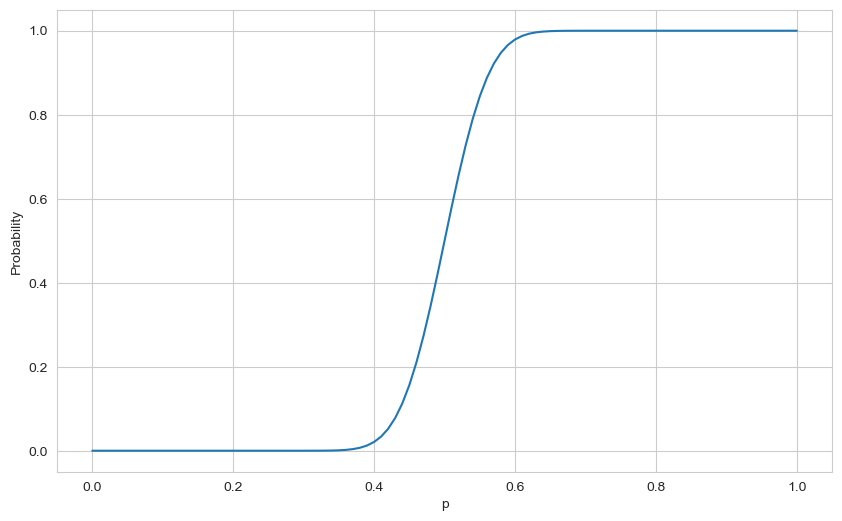

In [7]:
p_values = [0.01 * i for i in range(101)]
probabilities = []

for p in p_values:
    probability = sum([(np.math.factorial(101) / (np.math.factorial(i) * np.math.factorial(101 - i))) * p**i * (1-p)**(101-i) for i in range(51, 102)])
    probabilities.append(probability)

plt.figure(figsize=(10, 6))
plt.plot(p_values, probabilities)
plt.xlabel('p')
plt.ylabel('Probability')
plt.grid(True)
plt.show()


А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

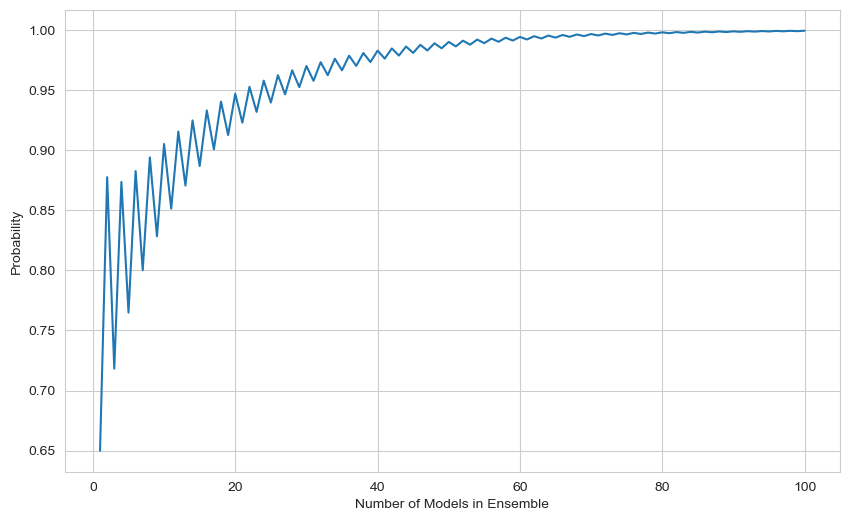

In [9]:
p = 0.65
num_models = np.arange(1, 101)

probabilities = []

for n in num_models:
    probability = sum([(np.math.factorial(n) / (np.math.factorial(k) * np.math.factorial(n - k))) * p**k * (1-p)**(n-k) for k in range((n+1)//2, n+1)])
    probabilities.append(probability)

plt.figure(figsize=(10, 6))
plt.plot(num_models, probabilities)
plt.xlabel('Number of Models in Ensemble')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

Опишите ваши наблюдения:
* С увеличением числа моделей вероятность правильной классификации также увеличивается. Это ожидаемо, поскольку ансамбль из большего числа моделей имеет больше шансов правильно классифицировать объект.
* В какой-то мент с ростом числа моделей вероятность правильной классификации выходит на плато

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [10]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(0, self.n_estimators):  
            np.random.seed(self.random_state + i)
            self.feat_ids_by_tree.append(np.random.choice(range(X.shape[1]), size=self.max_features, replace=False))

            pseudo_ids = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
            pseudo_X = X[pseudo_ids, :][:, self.feat_ids_by_tree[i]]
            pseudo_y = y[pseudo_ids]

            dt_clf = DecisionTreeClassifier(max_depth=self.max_depth, 
                                           max_features=self.max_features,
                                           random_state=self.random_state + i) 
            dt_clf.fit(pseudo_X, pseudo_y)
            self.trees.append(dt_clf)
        return self

    def predict_proba(self, X):
        ## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        proba = 0    
        for i, tree in enumerate(self.trees):         
            proba += tree.predict_proba(X[:, self.feat_ids_by_tree[i]])
        return proba/self.n_estimators

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [11]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

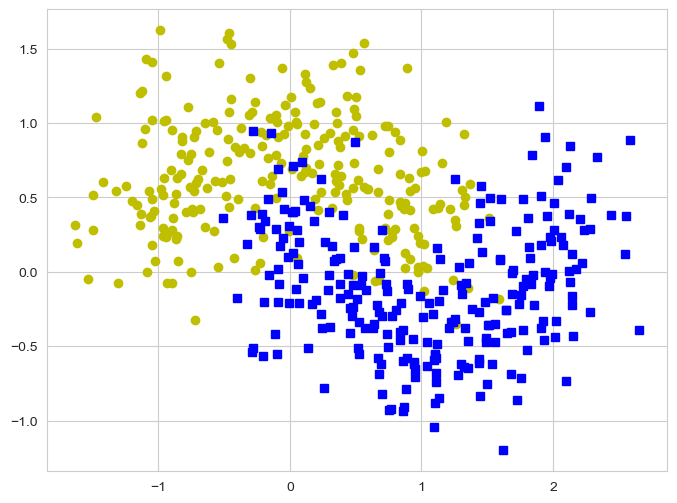

In [12]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [13]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

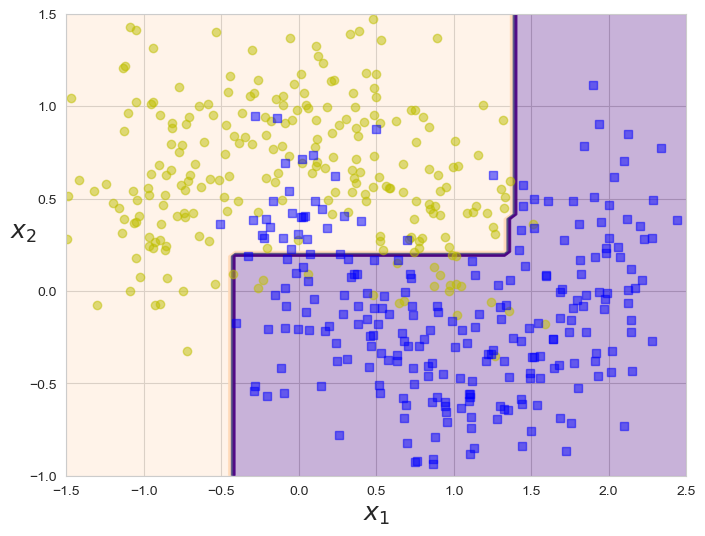

In [14]:
clf = RandomForestClassifierCustom(n_estimators=10, max_depth=3, max_features=2, random_state=SEED)
clf.fit(X, y)

plt.figure(figsize=(8, 6))
plot_decision_boundary(clf, X, y)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [15]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

Best Parameters: {'max_depth': 5, 'max_features': 2, 'n_estimators': 200}


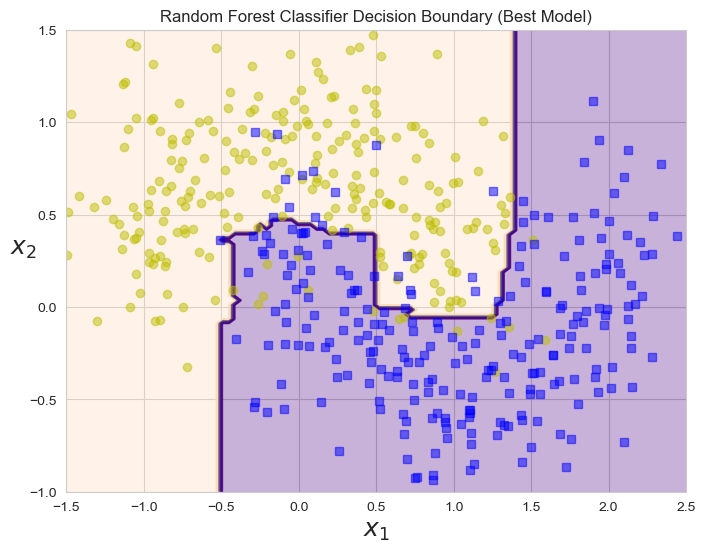

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
param_grid = {
    'n_estimators': [50, 100, 200], # я перебирала различные параметры, но 50 все равно лучший
    'max_depth': [3, 5, 7, 10, None],
    'max_features': [1, 2]
}

grid_search = GridSearchCV(RandomForestClassifierCustom(random_state=SEED), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_forest_clf = grid_search.best_estimator_

plt.figure(figsize=(8, 6))
plot_decision_boundary(best_forest_clf, X, y)
plt.title("Random Forest Classifier Decision Boundary (Best Model)")
plt.show()

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [17]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [18]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

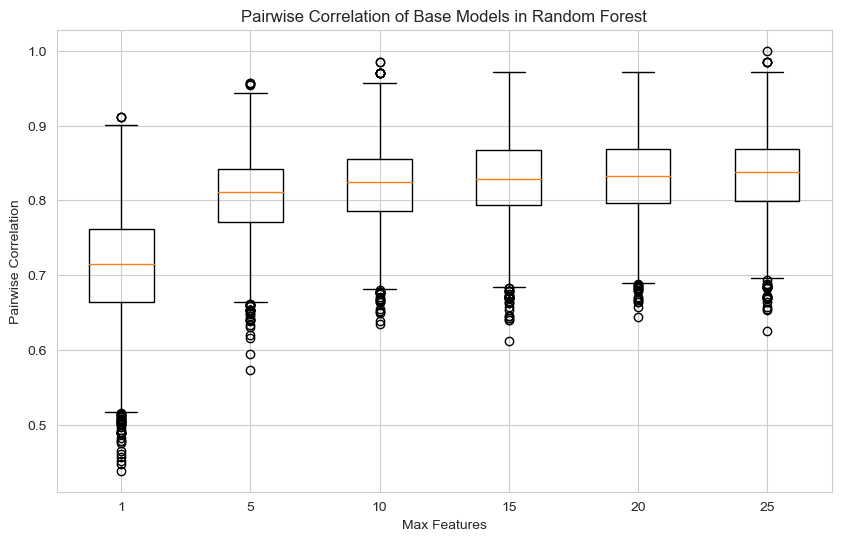

In [20]:
max_features_values = [1, 5, 10, 15, 20, 25]

correlation_results = {}

for max_features in max_features_values:
    rf_cls = RandomForestClassifier(n_estimators=100, max_features=max_features, random_state=42)
    rf_cls.fit(X_train, y_train)
    correlations = base_model_pair_correlation(rf_cls, X_test)
    correlation_results[max_features] = correlations

plt.figure(figsize=(10, 6))
plt.boxplot(correlation_results.values(), labels=correlation_results.keys())
plt.xlabel('Max Features')
plt.ylabel('Pairwise Correlation')
plt.title('Pairwise Correlation of Base Models in Random Forest')
plt.grid(True)
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [21]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

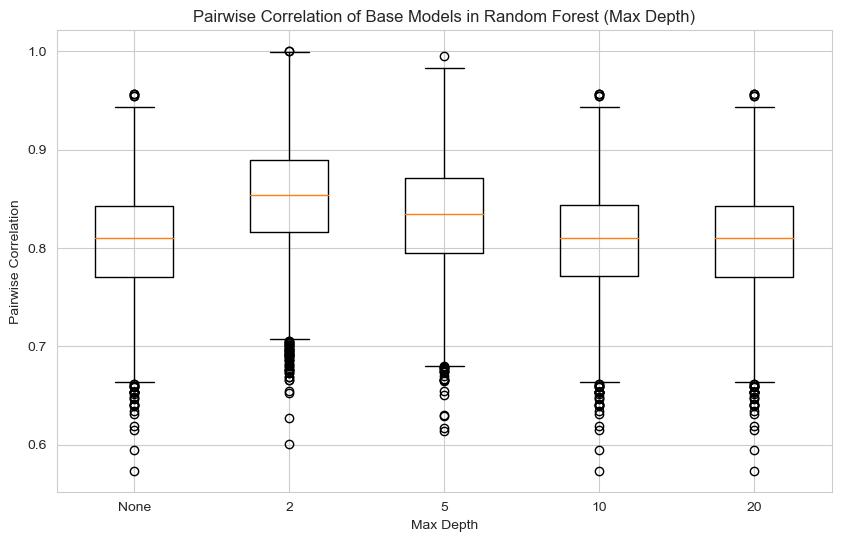

In [22]:
max_depth_values = [None, 2, 5, 10, 20]

correlation_results_depth = {}

for max_depth in max_depth_values:
    rf_cls = RandomForestClassifier(n_estimators=100, max_depth=max_depth, random_state=42)
    rf_cls.fit(X_train, y_train)
    correlations = base_model_pair_correlation(rf_cls, X_test)
    correlation_results_depth[str(max_depth)] = correlations

plt.figure(figsize=(10, 6))
plt.boxplot(correlation_results_depth.values(), labels=correlation_results_depth.keys())
plt.xlabel('Max Depth')
plt.ylabel('Pairwise Correlation')
plt.title('Pairwise Correlation of Base Models in Random Forest (Max Depth)')
plt.grid(True)
plt.show()


Опишите ваши наблюдения:
* С увеличением количества признаков корреляция также увеличивается, но в какой-то момент выходит на плато.
* Слишком малое или слишком большое количество признаков может привести к переобучению, но можно найти оптимальное количество признаков, которое достигает баланса между сложностью модели и ее способностью обобщать данные..емым

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [23]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [24]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [25]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(verbosity=-1, random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(verbosity=-1, boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

In [26]:
# # my code
# for _, model in base_models:
#     model.fit(X_train, y_train)

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [27]:
voting_hard = VotingClassifier(base_models, voting='hard')
voting_soft = VotingClassifier(base_models, voting='soft')

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8463991769547325
LGBMClassifier: 0.8132478632478634
LogisticRegression: 0.8500073681108163
GaussianNB: 0.8140676625250128
VotingClassifier: 0.8445754787218203
VotingClassifier: 0.8503633581946834


Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [28]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [29]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [30]:
voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

correlations_hard = base_model_pair_correlation_for_voting_clf(voting_hard, X_test)
correlations_soft = base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

correlations_hard.sort(key=lambda x: abs(x[2]), reverse=True)
correlations_soft.sort(key=lambda x: abs(x[2]), reverse=True)

models_to_exclude_hard = []
models_to_exclude_soft = []

correlation_threshold = 0.95

for est1, est2, corr in correlations_hard:
    if abs(corr) > correlation_threshold:
        models_to_exclude_hard.append(est1)
        models_to_exclude_hard.append(est2)

for est1, est2, corr in correlations_soft:
    if abs(corr) > correlation_threshold:
        models_to_exclude_soft.append(est1)
        models_to_exclude_soft.append(est2)

new_ensemble_hard = [est for est in voting_hard.estimators_ if est not in models_to_exclude_hard]
new_ensemble_soft = [est for est in voting_soft.estimators_ if est not in models_to_exclude_soft]

print("Модели, исключенные из ансамбля (hard voting):")
for model in models_to_exclude_hard:
    print(model.__class__.__name__)

print("\nМодели, исключенные из ансамбля (soft voting):")
for model in models_to_exclude_soft:
    print(model.__class__.__name__)

Модели, исключенные из ансамбля (hard voting):
LGBMClassifier
XGBClassifier
CatBoostClassifier
LGBMClassifier
ExtraTreesClassifier
CatBoostClassifier
SVC
LogisticRegression

Модели, исключенные из ансамбля (soft voting):
LGBMClassifier
XGBClassifier
CatBoostClassifier
LGBMClassifier
ExtraTreesClassifier
CatBoostClassifier
SVC
LogisticRegression


In [31]:
# Убедитесь, что список base_models не содержит модели CatBoostClassifier
#base_models = [(name, model) for name, model in base_models if 'CatBoostClassifier' not in str(model)]

new_voting_hard = VotingClassifier(estimators=base_models, voting='hard')
new_voting_soft = VotingClassifier(estimators=base_models, voting='soft')

new_voting_hard.fit(X_train, y_train)
new_voting_soft.fit(X_train, y_train)

f1_hard = f1_score(y_test, new_voting_hard.predict(X_test))
f1_soft = f1_score(y_test, new_voting_soft.predict(X_test))

print(f"F1 score для ансамбля с жестким голосованием: {f1_hard}")
print(f"F1 score для ансамбля с мягким голосованием: {f1_soft}")

F1 score для ансамбля с жестким голосованием: 0.8737864077669905
F1 score для ансамбля с мягким голосованием: 0.8737864077669905


Дальше не подбирала параметры получше

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [32]:
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [33]:
from my_awesome_eda import run_eda
df = data
run_eda(df)

In the observed table 
The number of observations/rows is 3333 
The number of parameters/columns is 21

Number of unique values in column State: 51
Number of unique values in column Account Length: 212
Number of unique values in column Area Code: 3
Number of unique values in column Phone: 3333
Number of unique values in column Int'l Plan: 2
Number of unique values in column VMail Plan: 2
Number of unique values in column VMail Message: 46
Number of unique values in column Day Mins: 1667
Number of unique values in column Day Calls: 119
Number of unique values in column Day Charge: 1667
Number of unique values in column Eve Mins: 1611
Number of unique values in column Eve Calls: 123
Number of unique values in column Eve Charge: 1440
Number of unique values in column Night Mins: 1591
Number of unique values in column Night Calls: 120
Number of unique values in column Night Charge: 933
Number of unique values in column Intl Mins: 162
Number of unique values in column Intl Calls: 21
Number 

,count,mean,std,min,25%,50%,75%,max
Account Length,3333.0,101.064806,39.822106,1.00,74.00,101.00,127.00,243.00
Area Code,3333.0,437.182418,42.371290,408.00,408.00,415.00,510.00,510.00
VMail Message,3333.0,8.099010,13.688365,0.00,0.00,0.00,20.00,51.00
Day Mins,3333.0,179.775098,54.467389,0.00,143.70,179.40,216.40,350.80
Day Calls,3333.0,100.435644,20.069084,0.00,87.00,101.00,114.00,165.00
Day Charge,3333.0,30.562307,9.259435,0.00,24.43,30.50,36.79,59.64
Eve Mins,3333.0,200.980348,50.713844,0.00,166.60,201.40,235.30,363.70
Eve Calls,3333.0,100.114311,19.922625,0.00,87.00,100.00,114.00,170.00
Eve Charge,3333.0,17.083540,4.310668,0.00,14.16,17.12,20.00,30.91
Night Mins,3333.0,200.872037,50.573847,23.20,167.00,201.20,235.30,395.00



Number of duplicate rows: 0


In [34]:
df.replace({"yes": 1, "no": 0, "True.": 1, "False.": 0}, inplace=True)

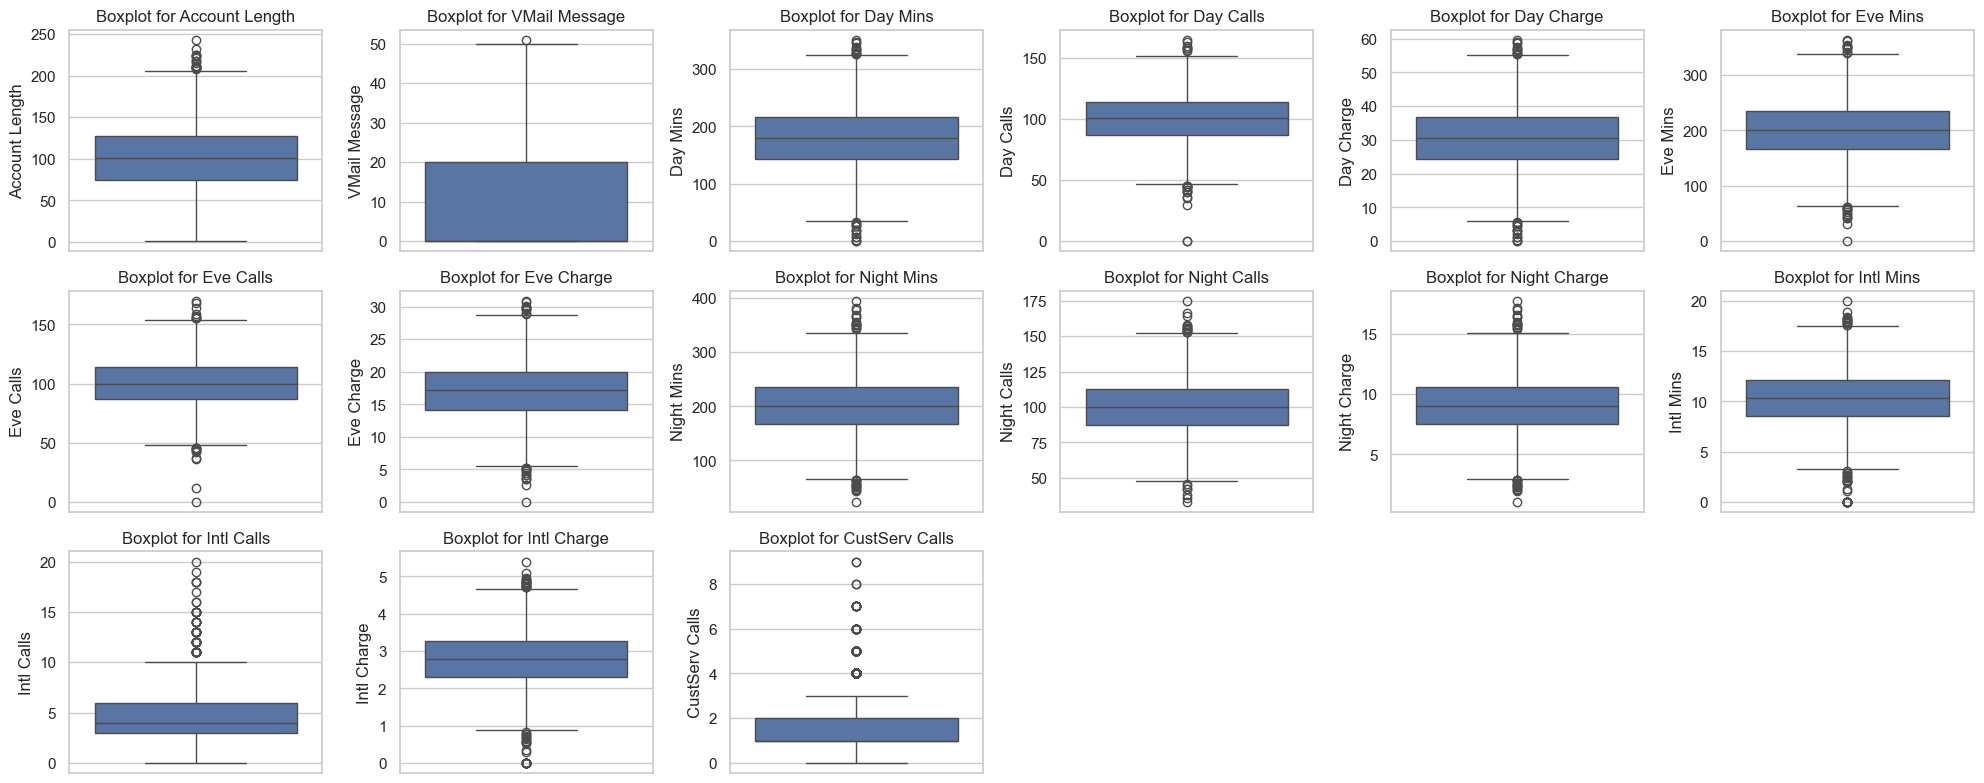

In [35]:
sns.set(style="whitegrid")
numerical_columns = ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 
                     'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 
                     'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls']

plt.figure(figsize=(20, 8))
for i, column in enumerate(numerical_columns):
    plt.subplot(3, 6, i+1)
    sns.boxplot(y=df[column])
    plt.title(f"Boxplot for {column}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Дропнем не особо важные (на мой взгляд) столбцы

In [36]:
data_clean = df.drop(['State', 'Phone', 'Area Code'], axis = 1) # "Day Mins", "Eve Mins", "Night Mins", "Intl Mins"])

In [37]:
X = data_clean.drop(['Churn?'], axis = 1)
y = data["Churn?"]

In [38]:
X.columns

Index(['Account Length', 'Int'l Plan', 'VMail Plan', 'VMail Message',
       'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls',
       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins',
       'Intl Calls', 'Intl Charge', 'CustServ Calls'],
      dtype='object')

In [39]:
cat_features = ["Int'l Plan", 'VMail Plan']  # булевые, можно отдельно не преобразовывать

num_features = ["Account Length", "VMail Message", 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls',
       'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins',
       'Intl Calls', 'Intl Charge', 'CustServ Calls']

preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_features),
    ('ohe', OneHotEncoder(), cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=SEED)

In [40]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=SEED))
])

xgb_pipeline.fit(X_train, y_train)

y_pred = xgb_pipeline.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       855
           1       0.95      0.72      0.82       145

    accuracy                           0.95      1000
   macro avg       0.95      0.86      0.89      1000
weighted avg       0.95      0.95      0.95      1000



In [41]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Best accuracy: 0.953705967227578


In [42]:
xgbrf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBRFClassifier(random_state=SEED))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(xgbrf_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best accuracy: 0.8551231033627115


In [43]:
lgbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=SEED, verbosity=-1))
])

param_grid_lgbm = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.1, 0.01, 0.001]
}

grid_search_lgbm = GridSearchCV(lgbm_pipeline, param_grid_lgbm, cv=5, scoring='accuracy', verbose=1)

grid_search_lgbm.fit(X_train, y_train)

print("Best parameters:", grid_search_lgbm.best_params_)
print("Best accuracy:", grid_search_lgbm.best_score_)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 300}
Best accuracy: 0.948133001259064


In [ ]:
catboost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', CatBoostClassifier(random_state=SEED, verbose=0))
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(catboost_pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


**Итого все модели показали плюс-минус схожее качество, если полагаться на значения метрик.**.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

Random forest Rene Magritt style by DALLE-2. 
Потому что руками рисовать на машинном обучении - не прикольно)

In [ ]:
from IPython.display import Image

path = "DALL·E 2024-03-13 16.42.55 - Random forest Rene Magritt style2.png"
Image(filename=path)

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**